In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
import re
from scipy.interpolate import griddata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import lstsq

from cofactor.features import Features
from cofactor.model import LatticePredictor
from cofactor.calculator import CofactorCalculator

In [4]:
featgen = Features.from_excel('data/elemental.xlsx')
model = LatticePredictor.from_file('models/model.pkl')
data = pd.read_csv('data/lattices.csv', index_col=0)

In [5]:
def features_from_df(df, element1, element2):
    df['T0'] = df['T0 (K)'] - 273
    df['Ms'] = df['Ms (K)'] - 273
    df['x'] = to_mol_percent(df, element1)
    df['y'] = to_mol_percent(df, element2)
    
    inputs = {
        element1: df['x'].values.reshape(-1, 1),
        element2: df['y'].values.reshape(-1, 1),
        'Zr': 1 - df['x'].values.reshape(-1, 1) - df['y'].values.reshape(-1, 1),
        'T': df.T0.values.reshape(-1, 1),
        'Ms': df.Ms.values.reshape(-1, 1),
        'hyst': (df.T0 - df.Ms).values.reshape(-1, 1),
    }
    X = featgen.get_features(inputs, model.features)
    
    return X

def get_cofactors(X, model):
    cofactors = []
    dV = []
    for tetr, mono in model.predict_lattice(X[model.features]):
        calc = CofactorCalculator(tetr, mono)
        cofactors.append(calc.get_cofactors())
        dV.append(calc.get_volume_change())

    return pd.concat([
        X,
        pd.DataFrame(cofactors),
        (pd.DataFrame(dV) - 1) * 100
    ], axis=1)

def get_gradient(results, element, prop):
    grad_dilute = results[[element, 'T', prop]][:2].diff().iloc[-1]
    
    dT_dx = grad_dilute['T'] / grad_dilute[element]
    dL_dx = grad_dilute[prop] / grad_dilute[element]
    
    return dT_dx, dL_dx

def to_mol_percent(df, element):
    def get_column(df, element):
        for col in df.columns:
            if element in col:
                return col
    
    col = get_column(df, element)
    x = df[col] / 100
    num = re.findall(element + '(\d)O', col)
    if len(num) == 0:
        return x

    return x / (int(num[0]) - x)

### Design charts

In [6]:
UNCERTAINTY_LAMBDA = 0.001145
PATH = 'data/quaternary/'

In [16]:
for file in ['La_Y.csv']:
    element1, element2 = file.strip('.csv').split('_')
    df = pd.read_csv(os.path.join(PATH, file)).dropna()
    X = features_from_df(df, element1, element2)
    results = get_cofactors(X, model)

In [17]:
grid_x, grid_y = np.mgrid[0:0.05:100j, 0:0.006:100j]
z = griddata((results['La'].values, results['Y'].values), results['B_lambda'].values, (grid_x, grid_y), method='linear')

In [18]:
def fit_plane(results, element1, element2, output):
    X = np.stack([results[element1], results[element2], np.ones_like(results[element2])], axis=1)
    coef, _, _, _ = lstsq(X, results[output])
    def plane(x, y):
        xy = np.stack([x, y, np.ones_like(y)], axis=1)
        return xy @ coef.reshape(-1, 1)
    
    return plane

In [19]:
lambda_plane = fit_plane(results, 'La', 'Y', 'B_lambda')
T_plane = fit_plane(results, 'La', 'Y', 'T')
Ms_plane = fit_plane(results, 'La', 'Y', 'Ms')

In [20]:
L = lambda_plane(grid_x.reshape(-1), grid_y.reshape(-1)).reshape(grid_x.shape)
T = T_plane(grid_x.reshape(-1), grid_y.reshape(-1)).reshape(grid_x.shape)
Ms = Ms_plane(grid_x.reshape(-1), grid_y.reshape(-1)).reshape(grid_x.shape)

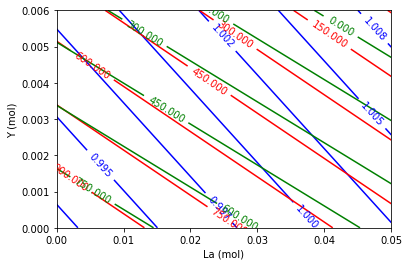

In [21]:
fig, ax = plt.subplots()

CS = ax.contour(
    grid_x, grid_y, L,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors='blue',
    label=r'$\lambda_2$'
)

ax.clabel(CS, CS.levels, inline=True, fontsize=10)

CS2 = ax.contour(
    grid_x, grid_y, T,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors='red',
)
ax.clabel(CS2, CS2.levels, inline=True, fontsize=10)

CS3 = ax.contour(
    grid_x, grid_y, Ms,
    extent=(grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()),
    colors='green',
)
ax.clabel(CS3, CS3.levels, inline=True, fontsize=10)
    
# set the limits of the plot to the limits of the data
ax.axis([grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()])

ax.set_xlabel('La (mol)')
ax.set_ylabel('Y (mol)')

# ax.legend()
plt.show()